In [95]:
import import_ipynb
from BankFindSearch import search

### Demo for ```search``` function

In [96]:
search('summary', 'STNAME: "North Carolina" AND YEAR:2019', ['ASSET', 'STNAME', 'YEAR'])

[{'YEAR': '2019',
  'STNAME': 'North Carolina',
  'ASSET': 2383515137,
  'ID': 'CB_2019_37'},
 {'YEAR': '2019',
  'STNAME': 'North Carolina',
  'ASSET': 2797093,
  'ID': 'SI_2019_37'}]

### Reading ```institutions.csv``` into pandas dataframe

In [97]:
import pandas as pd

#quantitative variables in institutions dataset 
numeric_cols = ['ASSET', 'DEP', 'DEPDOM', 'EQ', 'NETINC', 'NETINCQ', 'OFFDOM', 'OFFFOR', 'OFFOA', 'ROA', 'ROAPTX', 'ROAPTXQ', 'ROAQ',
               'ROE', 'ROEQ']

#categorical variables that use a binary indicator
flag_cols = ['ACTIVE', 'CFPBFLAG', 'CONSERVE', 'DENOVO', 'FEDCHRTR',
            'FORM31', 'INSDIF', 'INSTAG', 'LAW_SASSER_FLG', 'STCHRTR']

#both these types of variables can be used in analysis
cols = numeric_cols + flag_cols

In [98]:
data = pd.read_csv('institutions.csv', usecols = cols)

In [99]:
#map 'Y' to 1 and 'N' to 0 for variables using this notation
data['CONSERVE'] = data['CONSERVE'].map(dict(Y=1, N=0))
data['LAW_SASSER_FLG'] = data['LAW_SASSER_FLG'].map(dict(Y=1, N=0))

### Cleaning pandas dataframe

In [100]:
#display which variables have missing values and how many 
print('Missing values for each variable:')
for col in cols:
    count = 0
    for num in data[col]:
        if pd.isna(num):
            count+=1
    if (count > 0):
        print(f'{col}: {count}')

Missing values for each variable:
ASSET: 4005
DEP: 4005
DEPDOM: 4005
EQ: 4046
NETINC: 4005
NETINCQ: 4005
OFFDOM: 4005
OFFFOR: 4005
OFFOA: 4005
ROA: 4005
ROAPTX: 4005
ROAPTXQ: 4005
ROAQ: 4005
ROE: 4005
ROEQ: 4005
DENOVO: 4005
FORM31: 4005
INSTAG: 4005


In [101]:
#total number of datapoints that have at least one missing value
data.shape[0] - data.dropna().shape[0]

4046

In [102]:
#drop any datapoints(rows) with missing values
data_dropna = data.dropna()

### Demo and practice visualizing data

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [104]:
variables = ['YEAR','BRANCHES']

#Pull data from API using search according to specified variables
r = search("summary", 'STNAME:"United States" AND CB_SI:CB',variables)

#Convert search result to pandas dataframe
frame = pd.DataFrame(r, columns = variables)
x = frame[variables[0]]
y = frame[variables[1]]

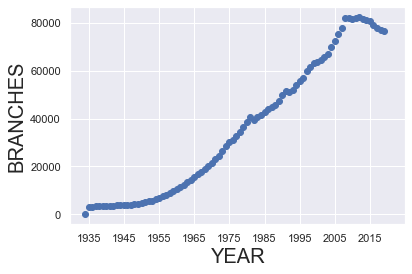

In [105]:
#Plot the pandas dataframe
plt.scatter(x,y)
plt.xlabel(variables[0], fontsize=20)
plt.ylabel(variables[1], fontsize=20)
ticks = [x for x in range(1, 96, 10)]
plt.xticks(ticks)
plt.show()

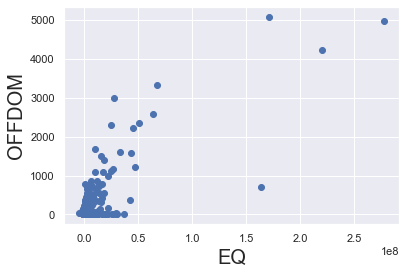

In [106]:
#Plot pandas dataframe already loaded from institutions.csv
variables = ['EQ','OFFDOM']
x = data[variables[0]]
y = data[variables[1]]

plt.scatter(x,y)
plt.xlabel(variables[0], fontsize=20)
plt.ylabel(variables[1], fontsize=20)
plt.show()

### Practice and preliminary XGBoost implementation

In [107]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

In [108]:
#Converting ROA variable to binary indicator (1 for positive ROA, 0 otherwise)
targets = [0 if x < 0 else 1 for x in data_dropna['ROA']]

#Drop quantitative variables - will focus on binary indicators
data_dropcols = data_dropna.drop(numeric_cols , axis=1)
data_dropcols['ROAb'] = targets

In [109]:
#Shuffle the dataset since we are about to balance
data_dropcols_shuff = data_dropcols.sample(frac=1, random_state=40)

In [120]:
#Check to see if target data is balanced (it is not)
sum(data_dropcols_shuff['ROAb']) / len(data_dropcols_shuff['ROAb'])

0.7275904172455897

In [121]:
#Balance the dataset to have an equal amount of 0 and 1 targets
num_zero_targets = len(targets) - sum(targets)
one_targets_counter = 0
indices = []

count = 0
for index,row in data_dropcols_shuff.iterrows():
    if (row['ROAb'] == 1):
        one_targets_counter += 1
        if one_targets_counter > num_zero_targets:
            indices.append(index)

data_balanced = data_dropcols_shuff.drop(indices)

In [122]:
#confirm data is now balanced
sum(data_balanced['ROAb']) / len(data_balanced['ROAb'])

0.5

In [113]:
#reshuffle to uniformly disperse 1s and 0s in target
data_balanced_shuff = data_balanced.sample(frac=1, random_state=42)

In [114]:
#partition the inputs and the targets
targets = data_balanced_shuff['ROAb']
inputs = data_balanced_shuff.drop('ROAb', axis = 1)

#scale inputs - not imperative since only dealing with binary variables, but good practice
inputs_scaled = preprocessing.scale(inputs)

#split into a train and test dataset - 90-10 split
train, test = train_test_split(inputs, test_size=0.10, random_state=42, shuffle=False)
train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [115]:
#load data into xgb data matrix
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [116]:
#perform xgboost training
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

[12:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [117]:
# make predictions on test dataset
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

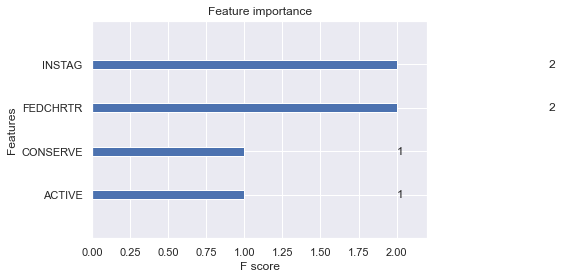

In [118]:
#plot feature importance
xgb.plot_importance(bst)

In [119]:
#calculate the accuracy of the model on the test dataset
count = 0

for i in range(len(test)):
    if preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == test_targets.iloc[i]:
        count+=1
print(count/len(test))

0.6120556414219475


##### Accuracy here is at least better than random guessing (50% accuracy), so there is some significance, but we hope to do better than 60% 